In [10]:
#importing libraries 

import pandas as pd
import numpy as np
from nltk import tokenize
from operator import itemgetter
import math
from difflib import SequenceMatcher

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import CountVectorizer

from textblob import Word
from spellchecker import SpellChecker
import re

from sentence_transformers import SentenceTransformer

stop_words =set(stopwords.words('english'))
data=pd.read_csv("hdfc_faq.csv")  # reading masterfile

In [11]:
stop_words =set(stopwords.words('english'))

In [12]:
unique = data['Question'].unique()
data =pd.DataFrame(unique,columns=['Question'])
data

,Question
0,How do I change my password?
1,When will I receive my changed ATM PIN?
2,Can I get my newly generated PIN online?
3,How can I register for Autopay?
4,Can Chip Credit cards be used anywhere?
...,...
2228,How to make payment for Insta Loan / Insta Jum...
2229,What is the disbursement time for Insta Loan /...
2230,How to check the available credit limit?
2231,What is the promo code to be entered in the lo...


In [13]:
keywords =[]
def Get_Output_list(data):  # Get output function gives out the first similar check results
        def get_top_n(dict_elem, n):  #function used in TF-IDF
            result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
            return result

        def synextract(a):  # This function is to extract all the synonyms and return a list of distinct synonyms
            synonyms = []
            for syn in wordnet.synsets(a):
                for lm in syn.lemmas():
                     synonyms.append(lm.name())
            return (list(set(synonyms)))

        def check_sent(word, sentences):  #function used in TF-IDF
            final = [all([w in x for w in word]) for x in sentences] 
            sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
            return int(len(sent_len))

        from difflib import SequenceMatcher 
        def similar(a, b):  # this function is used to calculate similar score using sequence matcher
            output=SequenceMatcher(None, a, b).ratio()
            return output        
        for question in data['Question']:
            total_sentences = tokenize.sent_tokenize(question)
            total_sent_len = len(total_sentences)
            total_words =question.split()
            total_word_length = len(total_words)
            tf_score ={}
            for each_word in total_words:
                each_word = each_word.replace('.','')
                if each_word not in stop_words:
                    if each_word in tf_score:
                        tf_score[each_word]+=1
                    else:
                        tf_score[each_word] =1

            tf_score.update((x,y/int(total_word_length)) for x,y in tf_score.items())
            idf_score = {}
            for each_word in total_words:
                each_word = each_word.replace('.','')
                if each_word not in stop_words:
                    if each_word in idf_score:
                        idf_score[each_word] = check_sent(each_word, total_sentences)
                    else:
                        idf_score[each_word] = 1

            idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())
            tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}
            check = list(get_top_n(tf_idf_score, 5).keys())
            keywords.append(check)
        data['tf_idf keywords'] = keywords
        return data

In [14]:
Get_Output_list(data)

,Question,tf_idf keywords
0,How do I change my password?,"[How, I, change, password?]"
1,When will I receive my changed ATM PIN?,"[When, I, receive, changed, ATM]"
2,Can I get my newly generated PIN online?,"[Can, I, get, newly, generated]"
3,How can I register for Autopay?,"[How, I, register, Autopay?]"
4,Can Chip Credit cards be used anywhere?,"[Can, Chip, Credit, cards, used]"
...,...,...
2228,How to make payment for Insta Loan / Insta Jum...,"[How, make, payment, Insta, Loan]"
2229,What is the disbursement time for Insta Loan /...,"[What, disbursement, time, Insta, Loan]"
2230,How to check the available credit limit?,"[How, check, available, credit, limit?]"
2231,What is the promo code to be entered in the lo...,"[What, promo, code, entered, loan]"


In [15]:
def second_simiar(old_list,user_input,similar_score):  #This function is used to filterout the final responses by calculating similar score with the user input to the results. 
    final_answer = {}
    for i in range(len(old_list)): #old_list contains the results from first sinmilarilty checker
        score = similar(user_input, old_list[i])
        if score > similar_score:
            if old_list[i] not in final_answer:
                final_answer[old_list[i]] = score
    
    sorted_Diction = sorted(final_answer.items(), key=lambda x:x[1],reverse=True) 
    
    #print(user_input)
    if (len(final_answer) >= 3):
        return (list(dict(sorted_Diction).keys())[:3])
    elif (len(final_answer) == 0):
        return ("No result found")
    else:
        return (list(dict(sorted_Diction).keys())[:len(final_answer)-1])
            

In [16]:
def check_sentence_spelling_3(sentence):  # this function is used for spell checker and append the correct spelled words to res
    
    spell = SpellChecker()    
    res =""
    avoid = ['elevance','carelon']
    
    words = sentence.split()
    
    words = [word.lower() for word in words]
    
    words = [re.sub(r'[^A-Za-z0-9]+', '', word) for word in words]

    for word in words:
        word = Word(word)
        if word not in avoid:
            misspelled = spell.unknown([word])
            for word in misspelled:
                result = spell.correction(word)
                if word != result:
                    word = result
            res += word + " "
        else:
            res += word + " "
    return (res)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


def Bert_Model(doc):
    n_gram_range = (1, 3)
    stop_words = "english"

# Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
    candidates = count.get_feature_names_out()
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(candidates)
    top_n = 10
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    return keywords

In [18]:
Bert = [0]*len(data)
data['Bert_keywords'] = Bert

In [19]:
data

,Question,tf_idf keywords,Bert_keywords
0,How do I change my password?,"[How, I, change, password?]",0
1,When will I receive my changed ATM PIN?,"[When, I, receive, changed, ATM]",0
2,Can I get my newly generated PIN online?,"[Can, I, get, newly, generated]",0
3,How can I register for Autopay?,"[How, I, register, Autopay?]",0
4,Can Chip Credit cards be used anywhere?,"[Can, Chip, Credit, cards, used]",0
...,...,...,...
2228,How to make payment for Insta Loan / Insta Jum...,"[How, make, payment, Insta, Loan]",0
2229,What is the disbursement time for Insta Loan /...,"[What, disbursement, time, Insta, Loan]",0
2230,How to check the available credit limit?,"[How, check, available, credit, limit?]",0
2231,What is the promo code to be entered in the lo...,"[What, promo, code, entered, loan]",0


In [20]:
def Bert_input_preprocess(new_output):
    final = []
    diction = {}
    indexx = 0
    bert_keys = []

    def synextract(a):  # This function is to extract all the synonyms and return a list of distinct synonyms
        synonyms = []
        for syn in wordnet.synsets(a):
            for lm in syn.lemmas():
                 synonyms.append(lm.name())
        return (list(set(synonyms)))

    def similar(a, b):  # this function is used to calculate similar score using sequence matcher
        output=SequenceMatcher(None, a, b).ratio()
        return output 

    def check_sentence_spelling_3(sentence):  # this function is used for spell checker and append the correct spelled words to res
    
        spell = SpellChecker()    
        res =""
        avoid = ['elevance','carelon','aadhar']
        
        words = sentence.split()
        
        words = [word.lower() for word in words]
        
        words = [re.sub(r'[^A-Za-z0-9]+', '', word) for word in words]

        for word in words:
            word = Word(word)
            if word not in avoid:
                misspelled = spell.unknown([word])
                for word in misspelled:
                    result = spell.correction(word)
                    if word != result:
                        word = result
                if word != None:
                    res += word + " "
            else:
                if word != None:
                    res += word + " "
        return (res)
    count = 0
    for question in data['Question']:
        count += 1
        print(question)
        try:
            check = Bert_Model(check_sentence_spelling_3(question))
            data['Bert_keywords'][count-1] = check
            bert_keys.append(check)
            print(count)
        
        except ValueError:
            pass
    return bert_keys


In [21]:
#Bert_keys = Bert_input_preprocess("how do i apply for leaves")

How do I change my password?


/var/folders/bv/54zrpjns611fgbwk4xqys0w40000gn/T/ipykernel_4855/497281111.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Bert_keywords'][count-1] = check
/var/folders/bv/54zrpjns611fgbwk4xqys0w40000gn/T/ipykernel_4855/497281111.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['change', 'password', 'change password']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['Bert_keywords'][count-1] = check


1
When will I receive my changed ATM PIN?
2
Can I get my newly generated PIN online?
3
How can I register for Autopay?
4
Can Chip Credit cards be used anywhere?
5
What information is required to use the e-monies NEFT service?
6
If the money is not credited to the beneficiarys account while using the e-monies NEFT service, will I get it back?
7
Can I use e-Monies NEFT for foreign remittances?
8
What is IFSC? How is it different from the MICR code?
9
What are the charges for the e-monies National Electronic Funds Transfer service?
10
How does the e-monies NEFT service differ from RGTS and EFT?
11
Is the e-Monies NEFT system better than the existing RBI-EFT system?
12
How do I check the IFSC of the receiving branch?
13
What information do I need to provide when using the RTGS funds transfer service?
14
If the money is not credited successfully, will the remitting customer get the funds back?
15
How long does it take for funds to be transferred from one account to another?
16
Are there min

In [22]:
#print(Bert_keys)

[['change', 'password', 'change password'], ['receive', 'changed', 'pin', 'receive changed', 'atm', 'atm pin', 'changed atm', 'receive changed atm', 'changed atm pin'], ['pin', 'generated', 'newly', 'generated pin', 'newly generated', 'online', 'newly generated pin', 'pin online', 'generated pin online'], ['register', 'autopsy', 'register autopsy'], ['used', 'chip', 'credit', 'cards', 'cards used', 'chip credit', 'credit cards', 'credit cards used', 'chip credit cards'], ['monies', 'information', 'use monies', 'required', 'monies service', 'required use', 'use monies service', 'information required', 'required use monies', 'information required use'], ['beneficiary', 'money credited', 'using monies', 'credited beneficiary account', 'monies service', 'beneficiary account', 'beneficiary account using', 'using monies service', 'account using monies', 'money credited beneficiary'], ['foreign', 'use', 'monies', 'use monies', 'monies foreign', 'remittance', 'use monies foreign', 'foreign rem

In [23]:
data

,Question,tf_idf keywords,Bert_keywords
0,How do I change my password?,"[How, I, change, password?]","[change, password, change password]"
1,When will I receive my changed ATM PIN?,"[When, I, receive, changed, ATM]","[receive, changed, pin, receive changed, atm, ..."
2,Can I get my newly generated PIN online?,"[Can, I, get, newly, generated]","[pin, generated, newly, generated pin, newly g..."
3,How can I register for Autopay?,"[How, I, register, Autopay?]","[register, autopsy, register autopsy]"
4,Can Chip Credit cards be used anywhere?,"[Can, Chip, Credit, cards, used]","[used, chip, credit, cards, cards used, chip c..."
...,...,...,...
2228,How to make payment for Insta Loan / Insta Jum...,"[How, make, payment, Insta, Loan]","[instar loan instar, make payment, jumbo loan,..."
2229,What is the disbursement time for Insta Loan /...,"[What, disbursement, time, Insta, Loan]","[disbursement time, jumbo loan smarter, time i..."
2230,How to check the available credit limit?,"[How, check, available, credit, limit?]","[available, limit, check, credit, check availa..."
2231,What is the promo code to be entered in the lo...,"[What, promo, code, entered, loan]","[code entered, promo code, booking, entered lo..."


In [49]:
#data.to_csv('Bert-TF-Keywords.csv', index=False) 

In [24]:
HDFC = pd.read_csv('Bert-TF-Keywords.csv')
HDFC

,Question,keywords,Bert_keywords
0,How do I change my password?,"['How', 'I', 'change', 'password?']","['change', 'password', 'change password']"
1,When will I receive my changed ATM PIN?,"['When', 'I', 'receive', 'changed', 'ATM']","['receive', 'changed', 'pin', 'receive changed..."
2,Can I get my newly generated PIN online?,"['Can', 'I', 'get', 'newly', 'generated']","['pin', 'generated', 'newly', 'generated pin',..."
3,How can I register for Autopay?,"['How', 'I', 'register', 'Autopay?']","['register', 'autopsy', 'register autopsy']"
4,Can Chip Credit cards be used anywhere?,"['Can', 'Chip', 'Credit', 'cards', 'used']","['used', 'chip', 'credit', 'cards', 'cards use..."
...,...,...,...
2228,How to make payment for Insta Loan / Insta Jum...,"['How', 'make', 'payment', 'Insta', 'Loan']","['instar loan instar', 'make payment', 'jumbo ..."
2229,What is the disbursement time for Insta Loan /...,"['What', 'disbursement', 'time', 'Insta', 'Loan']","['disbursement time', 'jumbo loan smarter', 't..."
2230,How to check the available credit limit?,"['How', 'check', 'available', 'credit', 'limit?']","['available', 'limit', 'check', 'credit', 'che..."
2231,What is the promo code to be entered in the lo...,"['What', 'promo', 'code', 'entered', 'loan']","['code entered', 'promo code', 'booking', 'ent..."


In [25]:
words_HDFC = HDFC['keywords'].apply(lambda x: re.findall(r"'([^']+)'", x))
words_bert_HDFC = HDFC['Bert_keywords'].apply(lambda x: re.findall(r"'([^']+)'", x))
TF_all_keys_HDFC = [value for sublist in words_HDFC for value in sublist]
bert_all_keys_HDFC= [value for sublist in words_bert_HDFC for value in sublist]

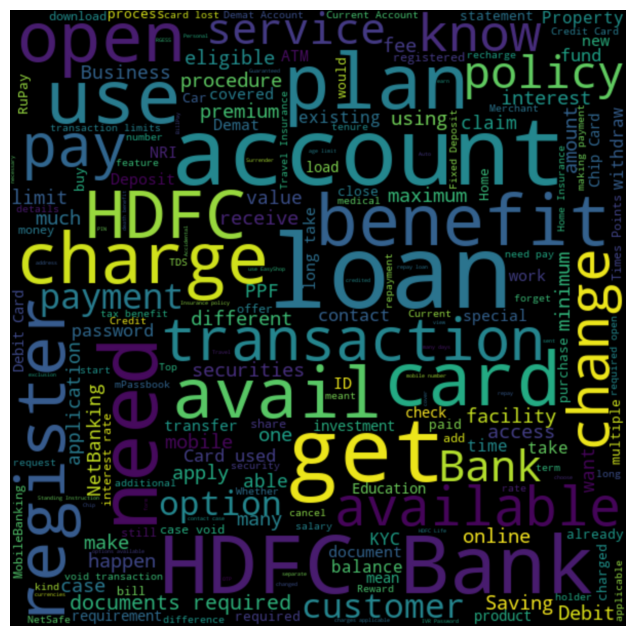

In [26]:
#TF - IDF WORD CLOUD

import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#print(total_words_list)
cleaned_words = [re.sub(r'[^a-zA-Z]', '', word) for word in TF_all_keys_HDFC]
#print(cleaned_words)
words = ' '.join(cleaned_words)
wordcloud = WordCloud(height=600,width=600,max_font_size=100, stopwords=stop_words).generate(words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis("off")
plt.show()

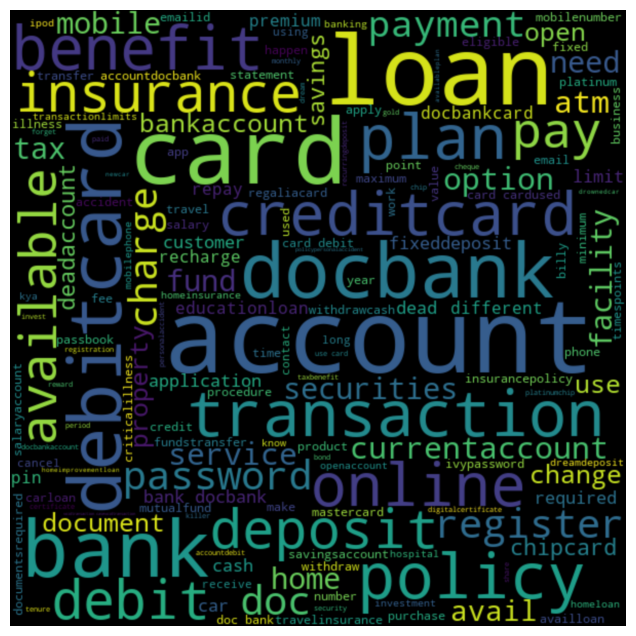

In [27]:
#BERT WORD CLOUD

import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#print(total_words_list)
cleaned_words = [re.sub(r'[^a-zA-Z]', '', word) for word in bert_all_keys_HDFC]
#print(cleaned_words)
words = ' '.join(cleaned_words)
wordcloud = WordCloud(height=600,width=600,max_font_size=100, stopwords=stop_words).generate(words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis("off")
plt.show()

In [28]:
def Get_Output_new(new_output):  # Get output function gives out the first similar check results
    final = []
    diction = {}
    count = 0
    for check in HDFC['keywords']:
        for i in range(len(new_output[0])):
            swap = new_output[0].copy()
            for j in range(len(check)):
                if len(set(synextract(new_output[0][i])) & set(synextract(check[j]))) > 0:
                    new_output[0][i] = check[j]
                    score = similar(new_output[0],check)
                    score = score - 0.05    # subtracting 0.05 just to keep the synonyms below the main keyword.
                    new_output[0][i] = swap[i]
                    if score >= 0.3:
                        if HDFC['Question'][count] not in final:
                            final.append(HDFC['Question'][count])
                            diction[HDFC['Question'][count]] = score
        count += 1

    sorted_Diction = sorted(diction.items(), key=lambda x:x[1],reverse=True)

    old_list = (list(dict(sorted_Diction).keys()))
    #print(old_list)
    #return old_list
    if (len(old_list) >= 3):
        return (list(dict(sorted_Diction).keys())[:3])
    elif (len(old_list) == 0):
        return ("No result found")
    else:
        return (list(dict(sorted_Diction).keys())[:len(old_list)-1])

In [29]:
def Did_you_mean_new(user_input):
    def get_top_n(dict_elem, n):  #function used in TF-IDF
        result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
        return result

    def synextract(a):  # This function is to extract all the synonyms and return a list of distinct synonyms
        synonyms = []
        for syn in wordnet.synsets(a):
            for lm in syn.lemmas():
                 synonyms.append(lm.name())
        return (list(set(synonyms)))

    def check_sent(word, sentences):  #function used in TF-IDF
        final = [all([w in x for w in word]) for x in sentences] 
        sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
        return int(len(sent_len))

     
    def similar(a, b):  # this function is used to calculate similar score using sequence matcher
        output=SequenceMatcher(None, a, b).ratio()
        return output 
    
    def second_simiar(old_list,user_input,similar_score):  #This function is used to filterout the final responses by calculating similar score with the user input to the results. 
        final_answer = {}
        for i in range(len(old_list)): #old_list contains the results from first sinmilarilty checker
            score = similar(user_input, old_list[i])
            if score > similar_score:
                if old_list[i] not in final_answer:
                    final_answer[old_list[i]] = score

        sorted_Diction = sorted(final_answer.items(), key=lambda x:x[1],reverse=True) 

        #print(user_input)
        if (len(final_answer) >= 3):
            return (list(dict(sorted_Diction).keys())[:3])
        elif (len(final_answer) == 0):
            return ("No result found")
        else:
            return (list(dict(sorted_Diction).keys())[:len(final_answer)-1])

    def Input_pre_process(user_input):  # This finction has spell checker, TF IDF vectoriser and returns the key words
        new_sentence = check_sentence_spelling_2(user_input)

        total_sentences = tokenize.sent_tokenize(new_sentence)
        total_sent_len = len(total_sentences)

        total_words =new_sentence.split()
        total_word_length = len(total_words)

        tf_score ={}
        for each_word in total_words:
            each_word = each_word.replace('.','')
            if each_word not in stop_words:
                if each_word in tf_score:
                    tf_score[each_word]+=1
                else:
                    tf_score[each_word] =1

        tf_score.update((x,y/int(total_word_length)) for x,y in tf_score.items())

        idf_score = {}
        for each_word in total_words:
            each_word = each_word.replace('.','')
            if each_word not in stop_words:
                if each_word in idf_score:
                    idf_score[each_word] = check_sent(each_word, total_sentences)
                else:
                    idf_score[each_word] = 1

    # Performing a log and divide
        idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

        tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}

        new_output = []
        new_output.append(list(get_top_n(tf_idf_score, 5).keys()))

        return (new_output)
    
    def check_sentence_spelling_2(sentence):  # this function is used for spell checker and append the correct spelled words to res
        
        spell = SpellChecker()    
        res =""
        avoid = ['aadhar','Aadhar']
        
        words = sentence.split()
        
        words = [word.lower() for word in words]
        
        words = [re.sub(r'[^A-Za-z0-9]+', '', word) for word in words]

        for word in words:
            word = Word(word)
            if word not in avoid:
                misspelled = spell.unknown([word])
                for word in misspelled:
                    result = spell.correction(word)
                    if word != result:
                        word = result
                res += word + " "
            else:
                res += word + " "
        return (res)
    
    def Get_Output_new(new_output):  # Get output function gives out the first similar check results
        final = []
        diction = {}
        count = 0
        for check in HDFC['keywords']:
            for i in range(len(new_output[0])):
                swap = new_output[0].copy()
                for j in range(len(check)):
                    if len(set(synextract(new_output[0][i])) & set(synextract(check[j]))) > 0:
                        new_output[0][i] = check[j]
                        score = similar(new_output[0],check)
                        score = score - 0.05    # subtracting 0.05 just to keep the synonyms below the main keyword.
                        new_output[0][i] = swap[i]
                        if score >= 0.3:
                            if HDFC['Question'][count] not in final:
                                final.append(HDFC['Question'][count])
                                diction[HDFC['Question'][count]] = score
            count += 1

        sorted_Diction = sorted(diction.items(), key=lambda x:x[1],reverse=True)
        #print(sorted_Diction)
        old_list = (list(dict(sorted_Diction).keys()))
        #print(old_list)
        #return old_list
        if (len(old_list) >= 3):
            return (list(dict(sorted_Diction).keys())[:3])
        elif (len(old_list) == 0):
            return ("No result found")
        else:
            return (list(dict(sorted_Diction).keys())[:len(old_list)-1])
        
    return Get_Output_new(Input_pre_process(user_input))

In [30]:
def Chatbot_response(user_input):
    if user_input in list(HDFC['Question']):
        indx = (list(HDFC['Question']).index(user_input))
        ans = data['answer'][indx]
        return ans
    else:
        return Did_you_mean_new(user_input)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


def Bert_Model(doc):
    n_gram_range = (1, 3)
    stop_words = "english"

# Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
    candidates = count.get_feature_names_out()
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(candidates)
    top_n = 10
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    return keywords

def Did_you_mean_new_bert(user_input):

    def synextract(a):  # This function is to extract all the synonyms and return a list of distinct synonyms
        synonyms = []
        for syn in wordnet.synsets(a):
            for lm in syn.lemmas():
                 synonyms.append(lm.name())
        return (list(set(synonyms)))

    def check_sent(word, sentences):  #function used in TF-IDF
        final = [all([w in x for w in word]) for x in sentences] 
        sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
        return int(len(sent_len))

     
    def similar(a, b):  # this function is used to calculate similar score using sequence matcher
        output=SequenceMatcher(None, a, b).ratio()
        return output 
    
    def second_simiar(old_list,user_input,similar_score):  #This function is used to filterout the final responses by calculating similar score with the user input to the results. 
        final_answer = {}
        for i in range(len(old_list)): #old_list contains the results from first sinmilarilty checker
            score = similar(user_input, old_list[i])
            if score > similar_score:
                if old_list[i] not in final_answer:
                    final_answer[old_list[i]] = score

        sorted_Diction = sorted(final_answer.items(), key=lambda x:x[1],reverse=True) 

        #print(user_input)
        if (len(final_answer) >= 3):
            return (list(dict(sorted_Diction).keys())[:3])
        elif (len(final_answer) == 0):
            return ("No result found")
        else:
            return (list(dict(sorted_Diction).keys())[:len(final_answer)-1])

    def Input_pre_process(user_input):  # This finction has spell checker, TF IDF vectoriser and returns the key words

        new_sentence = check_sentence_spelling_2(user_input)
        
        check = list(Bert_Model(new_sentence))
        
        new_output = []
        new_output.append(list(check))
        
        return (new_output)

    
    def check_sentence_spelling_2(sentence):  # this function is used for spell checker and append the correct spelled words to res
        
        spell = SpellChecker()    
        res =""
        avoid = ['hdfc','HDFC']
        
        words = sentence.split()
        
        words = [word.lower() for word in words]
        
        words = [re.sub(r'[^A-Za-z0-9]+', '', word) for word in words]

        for word in words:
            word = Word(word)
            if word not in avoid:
                misspelled = spell.unknown([word])
                for word in misspelled:
                    result = spell.correction(word)
                    if word != result:
                        word = result
                res += word + " "
            else:
                res += word + " "
        return (res)
    
    def Get_Output_new(new_output):  # Get output function gives out the first similar check results
        final = []
        diction = {}
        count = 0
        for check in HDFC['Bert_keywords']:
            for i in range(len(new_output[0])):
                swap = new_output[0].copy()
                for j in range(len(check)):
                    if len(set(synextract(new_output[0][i])) & set(synextract(check[j]))) > 0:
                        new_output[0][i] = check[j]
                        score = similar(new_output[0],check)
                        score = score - 0.05    # subtracting 0.05 just to keep the synonyms below the main keyword.
                        new_output[0][i] = swap[i]
                        if score >= 0.3:
                            if HDFC['Question'][count] not in final:
                                final.append(HDFC['Question'][count])
                                diction[HDFC['Question'][count]] = score
            count += 1

        sorted_Diction = sorted(diction.items(), key=lambda x:x[1],reverse=True)
        #print(sorted_Diction)
        old_list = (list(dict(sorted_Diction).keys()))
        #print(old_list)
        #return old_list
        if (len(old_list) >= 3):
            return (list(dict(sorted_Diction).keys())[:3])
        elif (len(old_list) == 0):
            return ("No result found")
        else:
            return (list(dict(sorted_Diction).keys())[:len(old_list)-1])
        
    return Get_Output_new(Input_pre_process(user_input))

In [36]:
user_input = 'what is the lmit of my creit crd'
Did_you_mean_new_bert(user_input)

'No result found'